<a href="https://colab.research.google.com/github/harrisuddin/F20DL/blob/main/F20DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets Discussion and Reasons to choose this dataset

FILL HERE...

## Setup

In [ ]:
import sys
assert sys.version_info >= (3, 5)
# Python ≥3.5 is required


In [ ]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [ ]:
# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import requests
import io


In [ ]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Get the data

In [ ]:
raw_data_url = "https://raw.githubusercontent.com/harrisuddin/F20DL/main/Airbnb_Open_Data.csv"
def load_bnb_data(url=raw_data_url):
  # download the csv file from github
  download = requests.get(url).content

  # read the downloaded content and put into dataframe
  df = pd.read_csv(io.StringIO(download.decode("utf-8")),index_col=0,infer_datetime_format=True,dayfirst=False,parse_dates=['last review','Construction year'],dtype={'id':'int','NAME':'string','host id':'int','host_identity_verified':'string' ,'host name':'string','neighbourhood group':'string','neighbourhood':'string','lat':'float','long':'float','country':'string','country code':'string', 	'...':'string','service fee':'string','minimum nights':'float','number of reviews':'float','reviews per month':'float','review rate number':'float','calculated host listings count':'float','availability 365':'float','house_rules':'string','license':'string'
})
  return df

In [ ]:
bnb_data = load_bnb_data()

In [ ]:
#Filters the bnb df to only contain values that makes sense in the context of a year such as availability and minimum nights as neither can go above 365 or below 0
bnb_data=bnb_data[(bnb_data['availability 365']>=0)&(bnb_data['availability 365']<=365)&(bnb_data['minimum nights']<=365)&(bnb_data['minimum nights']>=0)]


In [ ]:
#This method prints information about a DataFrame including the dtype and columns, non-null values and memory usage.
#changing the 2 prices to ints for better analysis
bnb_data[bnb_data.columns[14]] = bnb_data[bnb_data.columns[14]].replace('[\$,]', '', regex=True).astype(float)
bnb_data[bnb_data.columns[15]] = bnb_data[bnb_data.columns[15]].replace('[\$,]', '', regex=True).astype(float)
bnb_data[bnb_data.columns[16]] = bnb_data[bnb_data.columns[16]].replace('[\$,]', '', regex=True).astype(float)
bnb_data.info() 
#Q2 Can you tell if there are any missing values? If yes, which attributes contain missing values ? 
#bnb_data.info() is used to find how many instances have missing values by comparing entry count and Non-Null values 
#most incomplete attribute is license, house rules, reviews per month and review rate number. 
#However in this case a null value could mean no reviews were done rather than the data being missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

In [ ]:
bnb_data.head()

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [ ]:
bnb_data["lat"].value_counts()
# Q3 What does the value_count() method display?
# Returns the count of unique values in the dataset

40.76411    36
40.71813    32
40.76125    28
40.73756    27
40.72440    25
            ..
40.57718     1
40.66649     1
40.62918     1
40.62845     1
40.84753     1
Name: lat, Length: 21991, dtype: int64

In [ ]:
# This method shows a statistical summary of the numerical attributes 
bnb_data.describe() 

,id,host id,lat,long,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,1.025990e+05,1.025990e+05,102591.000000,102591.000000,102385.000000,102352.000000,102326.000000,102190.000000,102416.000000,86720.000000,102273.000000,102280.000000,102151.000000
mean,2.914623e+07,4.925411e+10,40.728094,-73.949644,2012.487464,625.293536,125.026924,8.135845,27.483743,1.374022,3.279106,7.936605,141.133254
std,1.625751e+07,2.853900e+10,0.055857,0.049521,5.765556,331.671614,66.325739,30.553781,49.508954,1.746621,1.284657,32.218780,135.435024
min,1.001254e+06,1.236005e+08,40.499790,-74.249840,2003.000000,50.000000,10.000000,-1223.000000,0.000000,0.010000,1.000000,1.000000,-10.000000
25%,1.508581e+07,2.458333e+10,40.688740,-73.982580,2007.000000,340.000000,68.000000,2.000000,1.000000,0.220000,2.000000,1.000000,3.000000
50%,2.913660e+07,4.911774e+10,40.722290,-73.954440,2012.000000,624.000000,125.000000,3.000000,7.000000,0.740000,3.000000,1.000000,96.000000
75%,4.320120e+07,7.399650e+10,40.762760,-73.932350,2017.000000,913.000000,183.000000,5.000000,30.000000,2.000000,4.000000,2.000000,269.000000
max,5.736742e+07,9.876313e+10,40.916970,-73.705220,2022.000000,1200.000000,240.000000,5645.000000,1024.000000,90.000000,5.000000,332.000000,3677.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are ignored.

The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations fall.

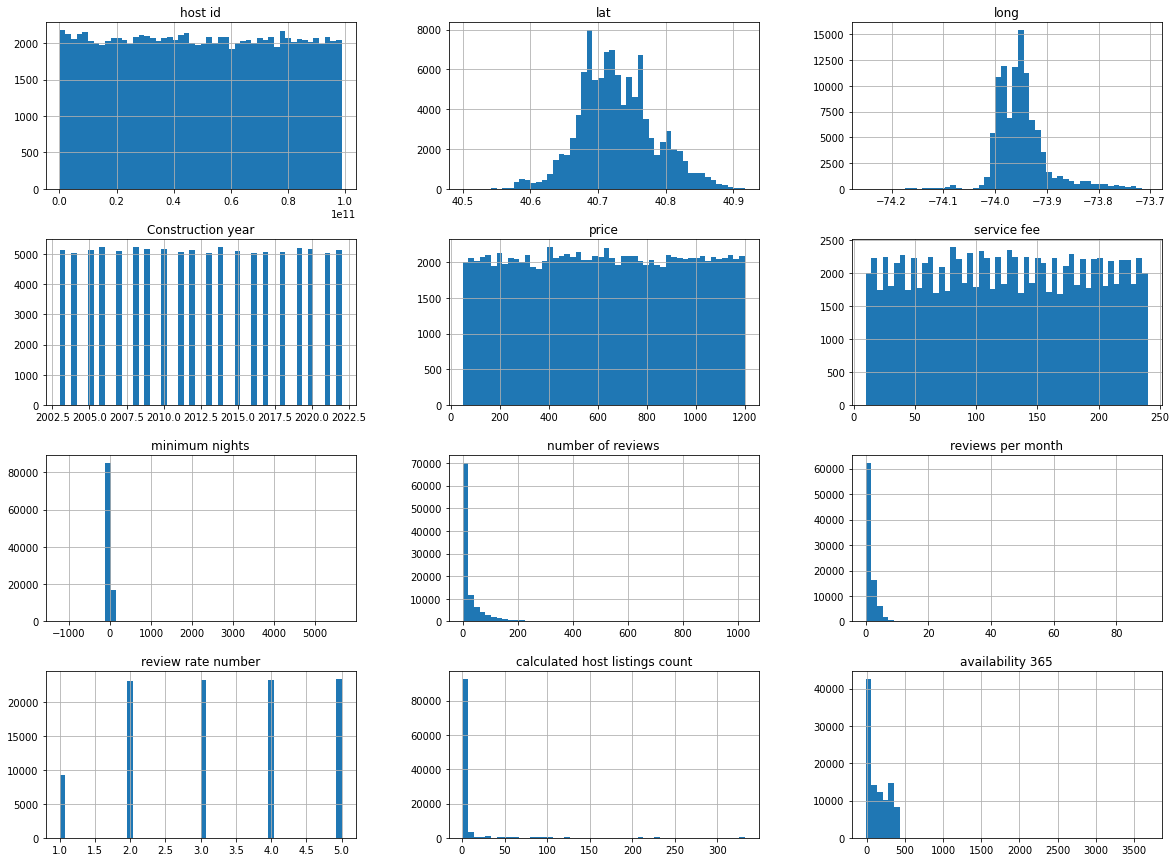

In [ ]:
# To plot a histogram for each numerical attribute
bnb_data.hist(bins=50, figsize=(20,15))
plt.show()
# Q4 List down the main observations you noted from the statistical summary and the histogram

#- host id is pointless to show like this
#- This is also true for some of the data statistics in such as construction year's std and mean do not provide a lot of insight or meaning
#- Max availability is 3677 which cannot be true in a 365 day/year same can be said for minimum nights at >365 or <0(before removing those values in line 11)
#- an near-equal number of 2, 3, 4, 5 star reviews which is annoying
#- same with construction year

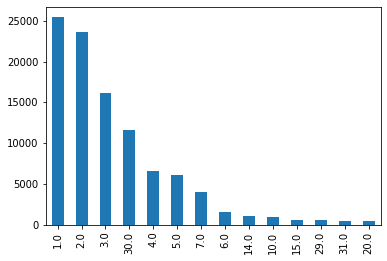

In [ ]:
# Q5 Now you will plot 3 different variations of the data, which one is more indicative and why?

# plotting the frequency of minimum required overnight stays per property
bnb_data['minimum nights'].value_counts()[:20]
bnb_data['minimum nights'].value_counts()[:20].plot.bar()

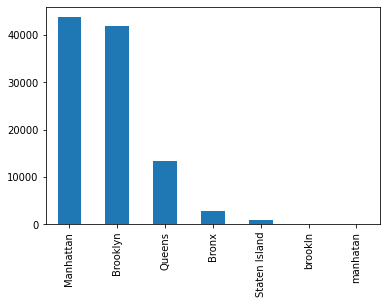

In [ ]:
# plotting the frequency of property neighbourhoods
bnb_data['neighbourhood group'].value_counts()[:20]
bnb_data['neighbourhood group'].value_counts()[:20].plot.bar()

# those like 5 or so undercapitalised ones lol
# includes typos

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


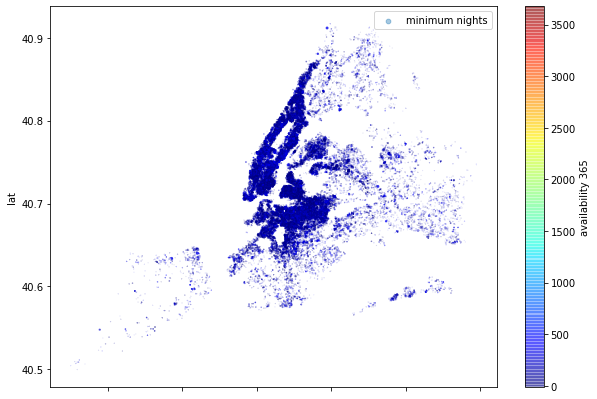

In [ ]:
bnb_data.plot(kind="scatter", x="long", y="lat", alpha=0.4,
    s=bnb_data["minimum nights"]/100, label="minimum nights", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
#EXAMPLE plots California housing prices:red is expensive, blue is cheap. Large circles indicate areas with larger populations.
#EXAMPLE The radius of each circle represents the district’s population(option s) and the color represents the price (option c).

# plots the price of a property against its longitude and latitude 


In [ ]:
# Now we will look at the correlation of all the attributes with the expected class attribute (median-house-value)
corr_matrix = bnb_data.corr() # computes the standard correlation coefficient (Pearson’s r) between every pair of attributes

In [ ]:
corr_matrix["review rate number"].sort_values(ascending=False)
# Q6 Which are the most correlated attributes with the output variable(i.e.median house value)?
# Does that make sense? 

review rate number                1.000000
reviews per month                 0.037526
id                                0.036633
calculated host listings count    0.024273
long                              0.015283
Construction year                 0.004753
host id                           0.003459
minimum nights                   -0.002167
lat                              -0.003917
service fee                      -0.004389
price                            -0.004576
availability 365                 -0.006217
number of reviews                -0.018412
Name: review rate number, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8669638d0>,
      dtype=object)

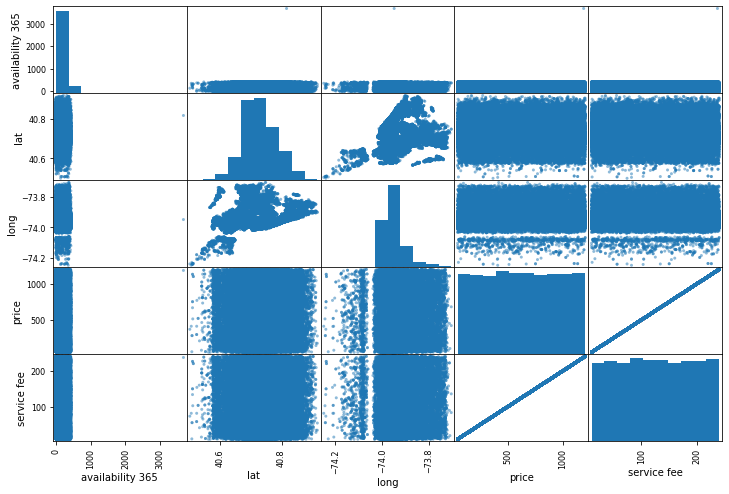

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["availability 365","price", "service fee",'minimum nights',
              'reviews per month','number of reviews',
              'review rate number','calculated host listings count']
scatter_matrix(bnb_data[attributes], figsize=(24, 14))
# Another way to check for correlation between attributes is to use the pandas scatter_matrix() function above
# Here we choose to plot 4 promising  numerical attributes against each other


(0.0, 1250.0, 0.0, 275.0)

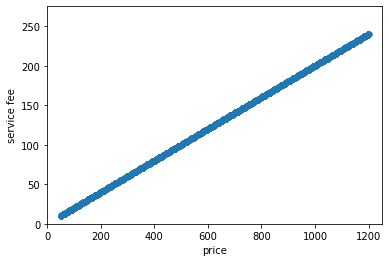

In [ ]:
# let’s zoom in on the correlation scatterplot "median house value & the median income,"
bnb_data.plot(kind="scatter", x="price", y="service fee",
             alpha=0.1)
plt.axis([0, 1250, 0, 275])
#Q7 Describe the plot below. What does this indicate? Do you have an explanation for the solid line?


#theres a direct correlation between a bnb's price and its service fee
#bnb's price may include the service fee as a sum

# Experimenting with Attribute Combinations

In [ ]:
# Here you will generate new features. This is what we call feature engineering
# Q8 What are the new features that you are generating? Do they make sense ?

bnb_data["minimum stay cost per night"] = bnb_data["price"]/bnb_data["minimum nights"]
#others are from the example

#bnb_data["bedrooms_per_room"] = bnb_data["total_bedrooms"]/bnb_data["total_rooms"]
#bnb_data["population_per_household"]=bnb_data["population"]/bnb_data["households"]

In [ ]:
corr_matrix = bnb_data.corr()
corr_matrix["minimum stay cost per night"].sort_values(ascending=False)
# Now you are checking the correlations given the new features 
# Q9 Did you get better features ?

minimum stay cost per night       1.000000
service fee                       0.530765
price                             0.530461
reviews per month                 0.242171
number of reviews                 0.109877
long                              0.094772
Construction year                 0.004372
host id                           0.002453
review rate number               -0.003897
lat                              -0.008705
availability 365                 -0.011339
calculated host listings count   -0.100330
minimum nights                   -0.194805
Name: minimum stay cost per night, dtype: float64

In [ ]:
#Q10 Plot the scatter plot of the rooms_per_household against median_house_value
#Q11 Now use the housing describe method to view the statistical summary of the dataset 

In [ ]:
# y = bnb_data["price"]
# y = y.dropna(how='any',axis=0)
X = bnb_data.drop(columns=["NAME", "host id", "host_identity_verified", "host name", "neighbourhood group", "neighbourhood", "country", "country code", "instant_bookable", "cancellation_policy", "room type", "last review", "house_rules", "license"])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price"])
X.describe()

,id,lat,long,Construction year,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,8.508600e+04,85086.000000,85086.000000,85086.000000,85086.000000,85086.000000,85086.000000,85086.000000,85086.000000,85086.000000,85086.000000
mean,2.955714e+07,40.727382,-73.948518,2012.485685,125.223233,7.439285,32.218567,1.374045,3.280457,7.026503,141.768963
std,1.621441e+07,0.056343,0.050362,5.762083,66.345303,27.944847,51.820270,1.745304,1.282601,29.411338,133.919441
min,1.001254e+06,40.504560,-74.249840,2003.000000,10.000000,-365.000000,1.000000,0.010000,1.000000,1.000000,-10.000000
25%,1.545903e+07,40.687670,-73.982130,2007.000000,68.000000,2.000000,3.000000,0.220000,2.000000,1.000000,6.000000
50%,3.078273e+07,40.721350,-73.953720,2012.000000,125.000000,3.000000,11.000000,0.740000,3.000000,1.000000,101.000000
75%,4.327037e+07,40.762660,-73.930880,2017.000000,183.000000,5.000000,38.000000,2.000000,4.000000,2.000000,266.000000
max,5.736024e+07,40.916970,-73.705220,2022.000000,240.000000,5645.000000,1024.000000,90.000000,5.000000,332.000000,3677.000000


In [ ]:
X_train, X_test, y_train, y_test = X[:40000], X[40000:], y[:40000], y[40000:]

In [ ]:
y_train_above_mean = (y_train > 626.110441)
y_test_above_mean = (y_test > 626.110441)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_above_mean)

SGDClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_above_mean, cv=3)

<img src="https://miro.medium.com/max/1051/1*fxiTNIgOyvAombPJx5KGeA.png" alt="Confusion Matrix" style="width: 400px;"/>

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_above_mean, y_train_pred)

array([[13395,  6698],
       [13272,  6635]])

In [ ]:
y_train_perfect_predictions = y_train_above_mean  # pretend we reached perfection
confusion_matrix(y_train_above_mean, y_train_perfect_predictions)

array([[20093,     0],
       [    0, 19907]])

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Precision is the number of correctly classified positive examples divided by the total number of examples that are classified as positive. 
precision_score(y_train_above_mean, y_train_pred)

0.4976374409360234

In [ ]:
# Recall r is the number of correctly classified positive examples divided by the total number of actual positive examples in the test set. 
recall_score(y_train_above_mean, y_train_pred)

0.33329984427588283

In [ ]:
from sklearn.metrics import f1_score
# f1 score (or f-measure) combines the recall and precision, the higher the better the model
f1_score(y_train_above_mean, y_train_pred)

0.39921780986762934

In [ ]:
y_scores = sgd_clf.decision_function(X_train.iloc[[1]])
y_scores

array([7.59175978e+09])

In [ ]:
threshold = 0
y_some_row_pred = (y_scores > threshold)

In [ ]:
y_some_row_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_above_mean, cv=3,
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_above_mean, y_scores)

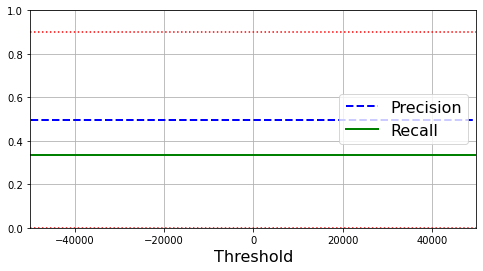

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

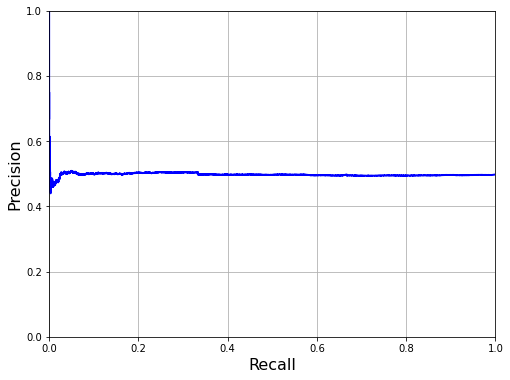

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
# plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
# plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
# plt.plot([0.4368], [0.9], "ro")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_above_mean, y_scores)

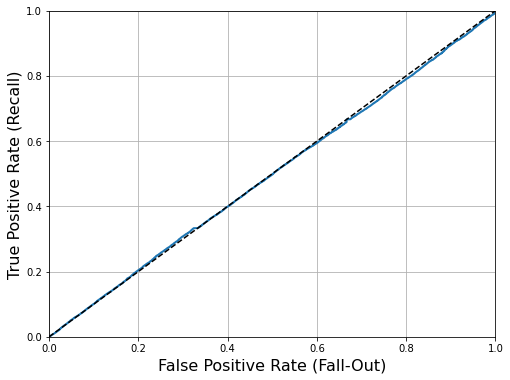

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
# plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
# plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
# plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_above_mean, y_scores)

0.4974847393637769

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_above_mean, cv=3, scoring="accuracy")

array([0.50232488, 0.50228756, 0.49763744])

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(bnb_data, test_size=0.2, random_state=42)
test_set.info()